In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from qulacsvis import circuit_drawer

In [2]:
nqubit = 3
c_depth = 5
time_step = 1.0

x_min = - 1.; x_max = 1.;
num_x_train = 100

func_to_learn = lambda x: np.exp(x)

random_seed = 0
np.random.seed(random_seed)

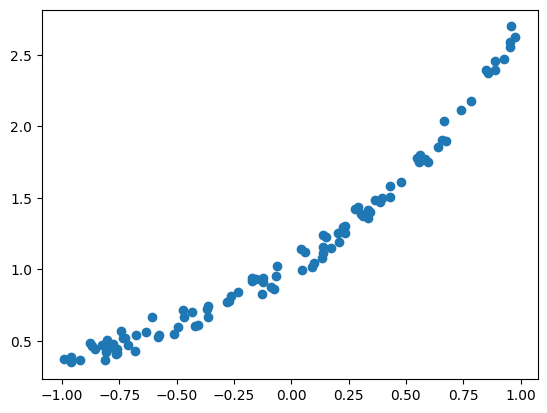

In [3]:
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [4]:
from qulacs import QuantumState, QuantumCircuit

state = QuantumState(nqubit)
state.set_zero_state()
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [5]:
# create the gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)
    
    return U

In [6]:
# test input state
x = 0.1
U_in(x).update_quantum_state(state) # U_in|000>
print(state.get_vector())

[-6.93804351e-01+7.14937415e-01j -3.54871219e-02-3.51340074e-02j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
  1.77881430e-03-1.76111422e-03j  8.73809020e-05+9.00424970e-05j]


In [7]:
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [8]:
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] を受け取り,
    関係ないqubitにIdentityを挿入して
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    という(2**nqubit, 2**nqubit)行列をつくる.
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## 1-qubit gateを並べてnp.kronでreduceする
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## 何もないsiteはidentity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [9]:
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit):
    Jx = -1. + 2.*np.random.rand()
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

from scipy.linalg import expm
time_evol_op = expm(-1.0j*time_step*ham)

In [10]:
time_evol_op.shape

(8, 8)

In [11]:
# transform into qulacs gates
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

In [12]:
from qulacs import ParametricQuantumCircuit

In [13]:
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

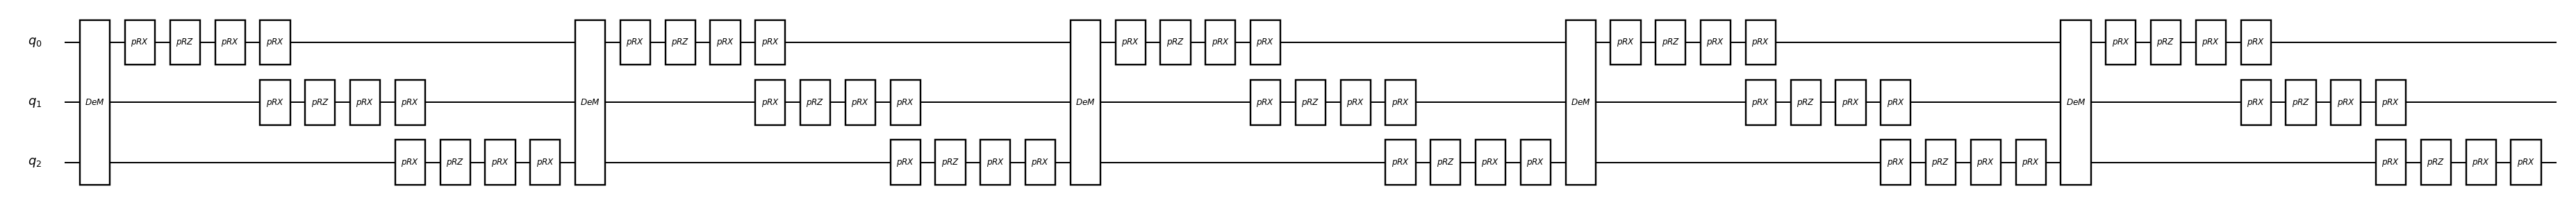

In [14]:
circuit_drawer(U_out, "mpl")

In [15]:
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

In [16]:
print(parameter_count)

60


In [17]:
# update parameters
def set_U_out(theta):    
    global U_out
    
    parameter_count = U_out.get_parameter_count()
    
    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

In [18]:
# Observable Z_0
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(3.,'Z 0')

In [19]:
obs.get_expectation_value(state)

2.9849623113198622

In [20]:
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    U_in(x).update_quantum_state(state)
    
    U_out.update_quantum_state(state)
    
    res = obs.get_expectation_value(state)
    
    return res

In [21]:
def cost_func(theta):
    
    set_U_out(theta)
    
    y_pred = [qcl_pred(x, U_out) for x in x_train]
    
    # quadratic loss
    L = ((y_pred - y_train)**2).mean()
    
    return L

In [22]:
cost_func(theta_init)

0.8242382284763409

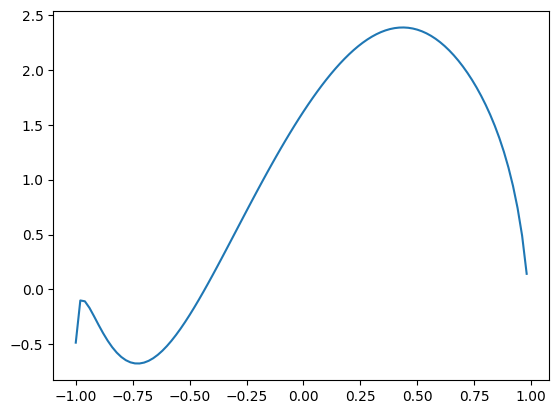

In [23]:
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

In [24]:
from scipy.optimize import minimize

In [25]:
%%time
result = minimize(cost_func, theta_init, method='Nelder-Mead') 

CPU times: user 1min 32s, sys: 46.1 s, total: 2min 18s
Wall time: 2min 38s


In [26]:
result.fun 

0.0024387012424994174

In [27]:
theta_opt = result.x 
print(theta_opt)

[5.74059813 0.72890616 3.21061887 0.86092941 3.98186415 2.62639243
 2.72340952 1.14329519 0.96523005 1.58777092 2.67263789 5.86109947
 4.99947188 4.90903537 5.74206655 0.78330001 3.19223464 2.89609797
 7.03329638 2.40325336 1.3166757  0.69994811 0.09660411 7.18615013
 4.10176667 4.12215186 2.3306043  4.01874837 0.37360795 3.41517063
 6.72884307 4.87458404 1.59829518 5.47517475 1.78326284 2.96600652
 6.13816968 5.52260484 3.62397111 5.43661556 1.75648637 5.20922911
 4.19196408 0.07795687 2.19444971 1.00989546 6.3630379  2.95855301
 2.95705557 3.9812162  2.5488718  0.97354896 4.90035069 1.12561555
 3.23930212 1.50828404 0.60082928 5.16615329 5.78259396 5.32062941]


In [28]:
# substitute parameters after optimization into U_out
set_U_out(theta_opt)

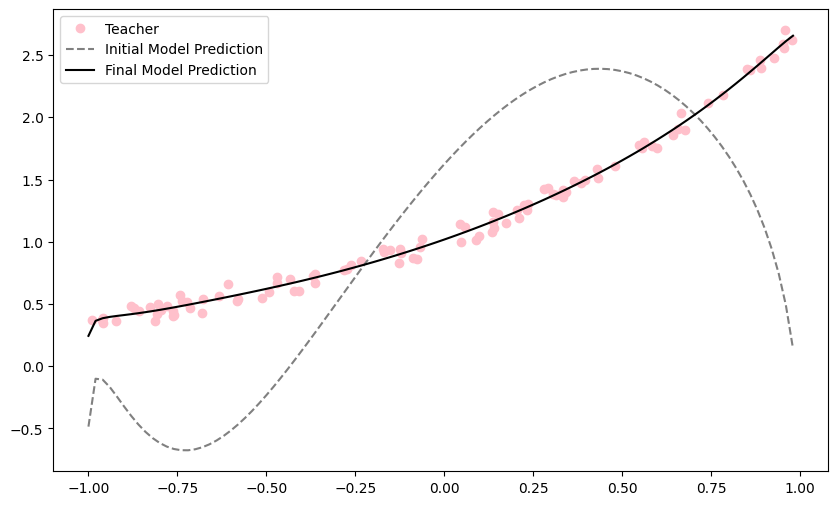

In [35]:
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

plt.plot(x_train, y_train, "o", color="pink",label='Teacher')

plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, color="black", label='Final Model Prediction')

plt.legend()
plt.show()